# Solving the n-Queens Problem using Local Search

## Instructions

Total Points: undergrad 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation (you can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or search algorithms),
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)
    
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n
    
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))


def show_board(board, cols = ['white', 'gray'], fontsize = 48):  
    """display the board"""
    
    n = len(board)
    
    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0): 
                display[i,j] = 1
    
    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap, 
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


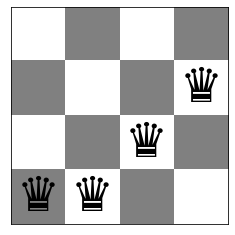

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [72]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


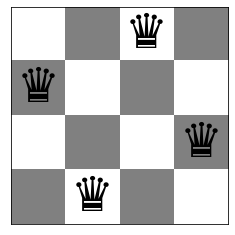

In [73]:
board = [1,3,0,2]
show_board(board)

## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

__Documentation__

* Neighbor states: each state has a maximum of $2n$ neighbors, which are defined as a board in which one queen has moved either up or down from the original board. In code, this is implemented in the $generateNeighbors$ function, calculated by treating the board as a vector, and adding or subtracting the n-dimensional basis vectors from the board vector.
* Steepest ascend implementation: the algorithm is implemented using a while loop. In each iteration, the neighbors of the current board are generated. The neighbors are then ranked by the objective function, so that the board with the smallest number of conflicts is chosen as the successor state. The loop then continues to the next iteration with the best successor. This is repeated until a max number of iterations is achieved.

__Additional helper functions__

In [74]:
def generateNeighbors(board):
    """Returns given board's neighboring states as a list"""

    neighbors = list()

    # Neighbors are calculated by doing a vector sum and subtraction of the board with the basis vectors of an nxn matrix
    basisVecs = np.eye(len(board), len(board), dtype=int)

    # Append vector sum and difference to list
    for i in range(len(board)):
        added = np.add(board, basisVecs[i])
        subbed = np.subtract(board, basisVecs[i])

        # Discard invalid boards with out of bounds choices
        if -1 not in added and len(board) not in added:
            neighbors.append(added)
        if -1 not in subbed and len(board) not in subbed:
            neighbors.append(subbed)

    return neighbors

In [75]:
def hillClimbing_steep(board, maxIter):
    iterations = 0
    y=list()
    while iterations < maxIter and conflicts(board) > 0:
        neighbors = generateNeighbors(board)
        if True not in [conflicts(x) < conflicts(board) for x in neighbors]: break # if no local moves are an improvement, the algorithm has finished

        board = min(neighbors, key=conflicts) #assign best neighbor to board
        iterations += 1
        y.append(conflicts(board))

    return board

y=hillClimbing_steep(random_board(100), 1000)


## Stochastic Hill Climbing 1 [2 Point]

Chooses randomly from among all uphill moves. Make the probability of the choice proportional to the steepness of the uphill move (i.e., with the improvement in conflicts). 

ValueError: x and y must have same first dimension, but have shapes (1000,) and (100,)

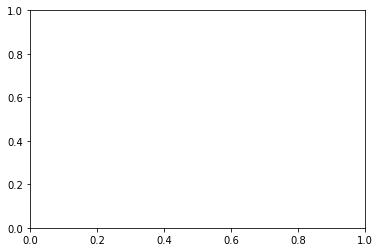

In [76]:
def hillClimbing_stoch(board, maxIter):
    iterations = 0
    y = list()
    while iterations < maxIter and conflicts(board) > 0:
        neighbors = generateNeighbors(board)
        randIdx = np.random.choice(range(len(neighbors)))
        randChoice = neighbors[randIdx]
        
        objDiff = conflicts(board) - conflicts(randChoice) # compare objective function value between old board and randomly selected neighbor
        acceptProb = objDiff / len(board) # probability is improvement over number of possible conflicts
        if acceptProb < np.random.uniform() and acceptProb > 0: # avoid selecting if it is not an improvement
            board = randChoice
        
        y.append(conflicts(board))
        iterations += 1

    return board

y=hillClimbing_stoch(random_board(100), 1000)
plt.plot(range(1000),y)

## Stochastic Hill Climbing 2 [2 Point]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [ ]:
def hillClimbing_stoch2(board, maxIter): #first choice hill climbing
    iterations = 0
    while iterations < maxIter and conflicts(board) > 0:
        # Generate random neighbors one at a time
        tries = 0
        while tries < 100: # max number of tries to get an improvement from current board before choosing randomly
            vec = [0] * len(board)
            vec[np.random.randint(0, len(board))] = np.random.choice([1, -1], p=[0.5, 0.5]) # random basis vector to be added to the current board
            neighbor = np.add(board, vec)
            if -1 not in neighbor and len(board) not in neighbor: # check if neighbor is valid
                if conflicts(neighbor) < conflicts(board):
                    board = neighbor
                    break
                if tries == 99:
                    board = neighbor
            
            tries += 1
        
        iterations += 1

    return board

for i in range(40):
    print(hillClimbing_stoch2(random_board(5), 1000))

[4 2 0 3 1]
[1 4 2 0 3]
[0 3 1 4 2]
[1 4 2 0 3]
[3 0 2 4 1]
[0 3 1 4 2]
[0 2 4 1 3]
[3 0 2 4 1]
[1 4 2 0 3]
[0 2 4 1 3]
[1 4 2 0 3]
[1 4 2 0 3]
[0 2 4 1 3]
[4 1 3 0 2]
[2 0 3 1 4]
[3 0 2 4 1]
[4 1 3 0 2]
[3 1 4 2 0]
[3 1 4 2 0]
[4 2 0 3 1]
[3 0 2 4 1]
[2 4 1 3 0]
[0 3 1 4 2]
[3 0 2 4 1]
[1 4 2 0 3]
[3 1 4 2 0]
[1 4 2 0 3]
[3 0 2 4 1]
[1 3 0 2 4]
[1 3 0 2 4]
[0 2 4 1 3]
[4 2 0 3 1]
[4 1 3 0 2]
[4 2 0 3 1]
[4 1 3 0 2]
[3 0 2 4 1]
[0 3 1 4 2]
[2 4 1 3 0]
[4 1 3 0 2]
[4 1 3 0 2]


## Hill Climbing Search with Random Restarts [1 Point]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algoithm several times with a new random initialization.

In [85]:
def hillClimbing_restarts(board, n, algorithm, maxIter):
    solutions = list()
    for i in range(100):
        attempt = algorithm(board, maxIter)
        if conflicts(attempt) == 0: return attempt # no more restarts required if solution is found
        solutions.append(attempt)
        board = random_board(n)
    return min(solutions, key=conflicts)

conflicts(hillClimbing_restarts(random_board(8), 8, hillClimbing_steep, 1000))

0

## Compare Performance [2 Points]

Use runtime and objective function value to compare the algorithms. 

* Use boards of different sizes to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 10 times) with different starting boards and report averages.

* How do the algorithms scale with problem size?

* What is the largest board each algorithm can solve in a reasonable amount time?

The example below times creating 100 random boards and calculating the conflicts. Reported is the average run time over `N = 100` runs.

For timing you can use the `time` package.

In [ ]:
import time

N = 100
total = 0

for i in range(N):
    t0 = time.time()
    for i in range(1,100): conflicts(random_board(8))
    t1 = time.time()
    total += t1 - t0

tm = total/N
    
print(f"This took: {tm * 1e3} milliseconds")

This took: 2.690424919128418 milliseconds


The `timit` package is useful to measure time for code that is called repeatedly.

In [ ]:
import timeit

N = 100

tm = timeit.timeit('for i in range(1,100): conflicts(random_board(8))', 
                   globals = globals(), number = N)/N

print(f"This took: {tm * 1e3} milliseconds")

This took: 2.5164559999998914 milliseconds


__Testing Strategy Pattern__

A simple strategy pattern class to test the algorithms

In [94]:
class LSTester:
    """Local search tester class"""
    def __init__(self, ti):
        self.algo = None
        self.iterations = list()
        self.times = list()
        self.scores = list()
        self.testIterations = ti # number of iterations per test
        self.boardSize = 0
        
    def select(self, a) -> None:
        """Changes the internal algorithm to the specified function handle"""
        self.algo = a

    def setBoardSize(self, n):
        self.boardSize = n

    def execute(self, useRestarts) -> None:
        total = 0

        for _ in range(self.testIterations):
            if useRestarts:
                t0 = time.time()
                hillClimbing_restarts(random_board(self.boardSize), self.boardSize, self.algo)
            else:
                t0 = time.time()
                self.algo(random_board(self.boardSize), 1000)
                
            t1 = time.time()
            total += t1 - t0

    def exportStats(self) -> list:
        print()


In [ ]:
# Code, results, charts and discussion go here

## Graduate student advanced task: Simulated Annealing [1 Point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


Implement simulated annealing for the n-Queens problem and compare its performance with the previouse algorithms.

In [ ]:
# Code and description go here

## More things to do

Implement a Genetic Algorithm for the n-Queens problem.

In [ ]:
# Code and description go here